**TRamWAy** - <u>T</u>he <u>Ra</u>ndo<u>m</u> <u>W</u>alk <u>A</u>nal<u>y</u>zer - features tools for processing single-molecule localization microscopy data.

This notebook introduces the [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object and its main functionalities, as of version *0.5*.

#### Table of contents
* [Parameter maps](#Parameter-maps)
* [SPT analysis and data structures](#SPT-analysis-and-data-structures)
* [Locations, trajectories and translocations](#Locations,-trajectories-and-translocations)
* [ROI definition](#ROI-definition)
* [Tessellation](#Tessellation), [time segmentation](#Time-segmentation) and [sampling](#Sampling)
* [Parameter estimation](#Parameter-estimation)
    * [DV inference](#DV-inference)
    * [Custom mappers](#Custom-mappers)
    * [Analyzing trajectories](#Analyzing-trajectories)
    * [Embarrassingly parallel mapper functions](#Embarrassingly-parallel-mapper-functions)

Let us first download the data required by this notebook:

In [1]:
from tutorial import *

download_RWAnalyzer_tour_data()

RWAnalyzer_tour_data.tar.bz2?inline=false


This notebook also requires some extra dependencies, including `scikit-learn` (required), `stopit` (optional) and those listed in the `roi` installation target for TRamWAy (only `polytope` is required):

In [2]:
import sys

!"{sys.executable}" -m pip install polytope cvxopt stopit scikit-learn

This notebook introduces (again) some basic concepts of the TRamWAy approach.

Some of the models inherited from InferenceMAP are used to estimate parameters of the dynamics of the fluorescent particles in the imaged biological sample. Such models focus on resolving the dynamics in space (and time), and are fed with individual displacements instead of entire trajectories.

Nevertheless, TRamWAy also features tools for extracting and quantifying trajectories, and two sections are dedicated to this topic.

Back to the mere TRamWAy approach that consists of resolving the dynamics in space, let us first have a look to example parameter maps.

# Parameter maps
A key product TRamWAy generates out of single particle tracking data is a collection of parameter maps that quantify the local dynamics of the observed molecules and their environment.

Let us load a data file and visualize one such map before we dive into the details of getting these parameters:

In [3]:
from tramway.analyzer import *

a              = RWAnalyzer()

In [4]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file also stores the result of analyses on these data.

For example this file contains effective potential maps. Let us visualize them:

In [5]:
# retrieve parameter maps
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)
map_label      = 'dv d=50 v=2 (ns)'
maps           = sampling.get_child(map_label)

In [6]:
# reload the time segmentation used to generate the maps
a.time.from_sampling(sampling)

In [7]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(8,7))

movie          = a.mapper.mpl.animate(fig, maps, feature='potential',
                    axes=ax, unit='std', overlay_locations=True)

In [8]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

# SPT analysis and data structures
Let us rewind and go step by step.

First, we initialized an [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer) object.

In [9]:
from tramway.analyzer import *

a = RWAnalyzer()

This object (here `a`) contains an attribute for addressing the single particle tracking data.

We initialized this attribute with a method that mutates the parent attribute itself and, in our case,
loads a *.rwa* file:

In [10]:
a.spt_data.from_rwa_file('data-examples/demo1.rwa')

For coders who prefer explicit assignment, the following alternative syntax is allowed:

    a.spt_data = spt_data.from_rwa_file('data-examples/demo1.rwa')

A *.rwa* file stores SPT data, together with results of the analyses performed on these data.
The analysis results are organized in a tree:

In [11]:
from tutorial import *

print_analysis_tree(a.spt_data.analyses, annotations=True)
# `print(a.spt_data.analyses)` works similarly

<class 'pandas.core.frame.DataFrame'>                              		<- original SPT data
	'gwr + 60s windowing' <class 'tramway.tessellation.base.Partition'>	<- data sampling
		'dv d=50 v=2 (ns)' <class 'tramway.inference.base.Maps'>	<- parameter maps


Here the tree features a single path, with the original data available at the top node:

In [12]:
a.spt_data.dataframe # or, equivalently, `a.spt_data.analyses.data`

n        x       y       t      dx      dy    dt
0         3  41.0294  7.0758   20.48  0.0453  0.1043  0.04
1         4  41.0882  7.0933   30.16 -0.0659  0.0746  0.04
2         5  41.0113  7.0608   30.36  0.0855  0.0980  0.04
3         6  41.0608  7.1048   30.60  0.0104  0.1294  0.04
4         7  41.0816  7.0902   30.68 -0.0945  0.0432  0.04
...     ...      ...     ...     ...     ...     ...   ...
12092  1856  41.0789  6.6456  794.88 -0.0431  0.0354  0.04
12093  1856  41.0358  6.6810  794.92  0.0290 -0.0924  0.04
12094  1856  41.0648  6.5886  794.96 -0.0611  0.0485  0.04
12095  1856  41.0037  6.6371  795.00  0.0998 -0.0704  0.04
12096  1856  41.1035  6.5667  795.04 -0.0335  0.0785  0.04

[12097 rows x 7 columns]

The `x` and `y` columns represent space coordinates, `t` represents time, `n` is the trajectory index, and the other columns are displacement information that are not always present at this level.

The above analysis tree exhibits a single sampling of these data and a single set of parameter maps inferred from the so-sampled data. There could be multiple samplings of the initial trajectory data, and multiple sets of parameter maps for each sampling. A label helps identify each processing step.

In the RWAnalyzer object, in addition to the above dataframe, the `spt_data` attribute stores more information such as `frame_interval` and `localization_error`.
If this information was not automatically loaded from the file, we would set:

In [13]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

The second level in the tree represents the data segmentation:

In [14]:
sampling_label = 'gwr + 60s windowing'
sampling       = a.spt_data.get_sampling(sampling_label)

# `sampling.data` is `a.spt_data.analyses[sampling_label].data`

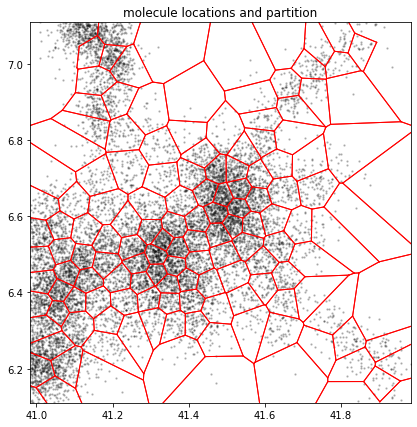

In [15]:
import matplotlib.pyplot as plt

fig, ax        = plt.subplots(figsize=(7,7))

ax.set_title('molecule locations and partition')

a.tesseller.mpl.plot(sampling, axes=ax)

The above plot shows the location data and the spatial segmentation.
In addition, the tessellation was combined with a time window, and the translocations were eventually assigned to the resulting spatio-temporal microdomains with extra constraints on the number of points per microdomain.

All this process is split in the *tessellation*, *time segmentation* and *sampling* of the data, and each step is controlled by a specific analyzer attribute.

The resulting data sampling found in the *demo1.rwa* file was obtained with the following parameters:

In [16]:
a.tesseller            = tessellers.GWR
a.tesseller.resolution = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

The third level of the analysis tree stores maps of dynamics parameters resolved in space and time:

In [17]:
# retrieve parameter maps
map_label = 'dv d=50 v=2 (ns)'
maps      = sampling.get_child(map_label)

# `maps.data` is `a.spt_data.analyses[sampling_label][map_label].data`

The above movie shows the time-varying diffusivity, which quantifies the random component in the local dynamics.

More inferred parameters are available in the `maps` object.
They are referred to as *features*, which names are explicitly listed in the object:

In [18]:
print(maps.data)

mode:                     stochastic.dv
diffusivity_prior:        50
potential_prior:          2
jeffreys_prior:           True
runtime:                  24088.606165647507
V0:                       0
allow_negative_potential: True
sigma:                    0.02
stochastic:               False
features:                 ['diffusivity', 'potential', 'force']
maps:                     <class 'pandas.core.frame.DataFrame'>


As an example, we can generate a movie for another feature, say the effective potential:

In [19]:
%%capture
# initialize the movie for a parameter map
import matplotlib.pyplot as plt

fig, ax   = plt.subplots(figsize=(8,7))

movie     = a.mapper.mpl.animate(fig, maps, feature='diffusivity',
                axes=ax, unit='std', overlay_locations=True, logscale=True)

In [20]:
# render the movie
from IPython.display import HTML

HTML(movie.to_jshtml())

These maps were obtained in a single inference with the following parameters:

In [21]:
a.mapper                          = models.DV()
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.V0                       = 0     # flat initial potential

... and code:

In [22]:
def sample_and_infer(self):
    """ `self` is the `RWAnalyzer` object """
    
    for f in self.spt_data: # for each SPT data file (this also works with a single file)
        
        # if not already loaded, the file is actually loaded at this point
        sptdata  = f.dataframe
        
        # keep only the molecules that move by more than the localization error
        sptdata  = f.discard_static_trajectories(sptdata)
        
        # apply the `tesseller.tessellate`, `time.segment` and `sampler.sample` steps all at once
        sampling = self.sampler.sample(sptdata)
        
        # parameter inference takes time...
        maps     = self.mapper.infer(sampling)
        
        # wrap the original `sampling` and `maps` objects in node-like objects;
        # this stores the analysis artefacts in the analysis tree for `f`
        sampling = commit_as_analysis(sampling_label, sampling, parent=f)
        maps     = commit_as_analysis(map_label, maps, parent=sampling)
        
        # save to file;
        # in most cases, it is preferable to let the RWAnalyzer automatically determine the output filepath
        f.analyses.save()
        

Here, `sampler.sample` calls the `tessellate` and `segment` methods of the `tesseller` and `time` attributes respectively. Of note, the `sampler` attribute would exhibit a working `sample` method even if not initialized.

At this point, `sample_and_infer` can run as-is:

```
sample_and_infer(a)
```

The code in the body of the function could run without making it a function,
but we do not want it to run now, as the `infer` step may take a few hours to complete.

As a function, the execution of `sample_and_infer` is also ready to be parallelized using the [pipeline capability](RWAnalyzer%20simple%20pipeline.ipynb) of [RWAnalyzer](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.RWAnalyzer).
For example, with a few additional lines of code, `sample_and_infer` execution can be delegated to a computer cluster and the resulting output file(s) retrieved onto the host that runs the Jupyter notebook.

### Summary
Before any analysis is run and an output *.rwa* file is generated, the SPT data often come as a text file.

To sum up, and as a transition to the next section, let us export the SPT data to an ascii file and start from scratch without printing or plotting anything:

In [23]:
a.spt_data.to_ascii_file('data-examples/demo1.txt')

In [24]:
from tramway.analyzer import *

a = RWAnalyzer()

Note the main difference:

In [25]:
a.spt_data.from_ascii_file('data-examples/demo1.txt')

In [26]:
a.spt_data.frame_interval         = 0.04 # in seconds
a.spt_data.localization_precision = 0.02 # in micrometers

a.tesseller                       = tessellers.GWR
a.tesseller.resolution            = .1

a.time.from_sliding_window(duration=60, shift=30)

a.sampler.from_nearest_neighbors(20)

a.mapper                          = models.DV()
a.mapper.diffusivity_prior        = 50
a.mapper.potential_prior          = 2
a.mapper.jeffreys_prior           = True
a.mapper.V0                       = 0     # flat initial potential

... and we are ready!

In [27]:
# sample_and_infer(a)

Note that, if you want to adapt `sampling_label` and `map_label`, you will have to redefine `sample_and_infer`.

# Locations, trajectories and translocations
Location and displacement information is made available in `pandas.DataFrame`s. However, there are subtle differences between trajectories and translocations.

Let us load some localization data:

In [28]:
import pandas as pd
pd.set_option('display.max_rows', 8)

In [29]:
from tramway.core import load_xyt

locations = load_xyt('data-examples/c05_low_density.tsf.xyt', columns=list('xyt'))
locations

x        y      t
0      26.6615  39.5796   0.06
1      26.1820  43.4160   0.06
2      27.0411  26.9305   0.06
3      29.1381  48.5524   0.06
...        ...      ...    ...
33547  55.8001  45.0347  31.20
33548  59.9244  36.4617  31.20
33549  58.5234  29.2296  31.20
33550  58.7866  36.8735  31.20

[33551 rows x 3 columns]

The `x` and `y` columns represent space, in $\mu m$, and `t` represents time, in $s$.

The frame interval appears to be 0.06 and, as can be seen above in the dataframe, the locations are ordered in time.

The `tramway.core` module exports convenience functions like `iter_frames` to loop over the locations grouped by frame.

## Localization data tracking
Let us track these data using the *non-tracking* tracker:

In [30]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06

This algorithm requires some hint about the values expected for diffusivity, plus an indication about the localization precision or error:

In [31]:
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

### Side note
Some key parameters such as `frame_interval` and `localization_precision` are available at multiple places.
These parameters are actually stored in the `spt_data` attribute:

In [32]:
a.spt_data.frame_interval

0.06

This has been made possible by the `tracker` attribute altering the `spt_data` attribute:

In [33]:
a.spt_data

... while it was beforehands:

In [34]:
RWAnalyzer().spt_data

## Tracking (continued)

In [35]:
a.tracker.track(locations, register=True)

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
...     ...      ...      ...    ...
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

The `track` method applied to the example localization file returned a `pandas.DataFrame` that represents the resulting trajectories.
Column `n` encodes the trajectory index.
Rows are locations, ordered first by trajectory index and second by time.

The `register=True` option made `track` append the series of trajectories to the `spt_data` attribute:

In [36]:
for f in a.spt_data:
    pass
f.dataframe

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
...     ...      ...      ...    ...
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

Note here that we had to loop over items in `a.spt_data`.
Indeed, the `track` method can be called multiple times, on different files, and consequently the `spt_data` attribute could contain multiple items.

Because these *data provider* attributes (others are `images` and `roi`) are always iterable and often contain a single item, the `tramway.analyzer` package exports some very simple convenience functions to get the first or unique item of such iterators:

In [37]:
trajectories = single(a.spt_data).dataframe
trajectories

n        x        y      t
0         1  26.1820  43.4160   0.06
1         1  26.2917  43.2076   0.12
2         2  27.0411  26.9305   0.06
3         2  27.3263  26.7477   0.12
...     ...      ...      ...    ...
12851  5098  47.0593  36.7691  31.14
12852  5098  47.3644  36.9945  31.20
12853  5099  36.9425  36.9245  31.14
12854  5099  36.7721  37.0181  31.20

[12855 rows x 4 columns]

We can now run the same type of analyses on the SPT data, as presented before.

## Representations for trajectories and translocations
The models underlying the main inference methods available in TRamWAy do not need entire trajectories, but only individual displacements, or translocations.

To make the notion of translocation visible, let us define a region of interest and crop the data within this ROI:

In [38]:
a.spt_data.bounds

n        x        y      t
min     1.0  19.8098  19.2550   0.06
max  5099.0  61.5214  58.6531  31.20

In [39]:
from tramway.core import crop

cropped_trajectories = crop(trajectories, [20.,20.,10.,10.], keep_nan=True)
cropped_trajectories

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    3  27.3263  26.7477   0.12     NaN     NaN   NaN
2    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
3    4  27.4235  26.5621   0.30     NaN     NaN   NaN
..  ..      ...      ...    ...     ...     ...   ...
95  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
96  47  27.0192  28.5049  29.40     NaN     NaN   NaN
97  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06
98  48  22.5791  28.7713  30.18     NaN     NaN   NaN

[99 rows x 7 columns]

We took a (huge) 10x10$\mu m$ area and found a hundred locations in it (these data are indeed low-density, as the filename stated).

*delta* columns were added: `dx`, `dy` and `dt`.
They encode the displacement from the location described in the same row.

The terminal location for each trajectory exhibits undefined *delta* values (NaN).
As such, the above data are still considered as trajectory data.

Translocations are the rows with defined displacement information:

In [40]:
translocations = crop(trajectories, [20.,20.,10.,10.])
translocations

n        x        y      t      dx      dy    dt
0    3  27.0411  26.9305   0.06  0.2852 -0.1828  0.06
1    4  27.2278  26.7087   0.24  0.1957 -0.1466  0.06
2    6  25.1349  23.8702   1.56  0.1845  0.0494  0.06
3    7  24.7621  27.4019   1.62 -0.1749  0.1544  0.06
..  ..      ...      ...    ...     ...     ...   ...
49  46  24.5129  25.5778  28.56 -0.0652 -0.0410  0.06
50  46  24.4477  25.5368  28.62  0.1256  0.0381  0.06
51  47  27.0603  28.2362  29.34 -0.0411  0.2687  0.06
52  48  22.5607  28.6995  30.12  0.0184  0.0718  0.06

[53 rows x 7 columns]

Some methods, <i>e.g.</i> for plotting trajectories, explicitly require trajectory data, while other methods require translocations only.

The `tramway.core` package exports conversion functions such as `trajectories_to_translocations` and `translocations_to_trajectories`.
This package also exports the `iter_frames` and `iter_trajectories` functions to iterate such dataframes over groups of rows.

# ROI definition
The above cropping can be generalized to many regions of interest using the `roi` attribute.
Regions of interest can be defined in many ways, as square areas centered at <i>e.g.</i> density peaks, or bounding boxes on the coordinates, including time, etc.


In [41]:
from tramway.analyzer import *

a                                    = RWAnalyzer()
a.tracker.from_non_tracking()
a.tracker.frame_interval             = 0.06
a.tracker.estimated_high_diffusivity = 0.3
a.tracker.localization_precision     = 0.03

In [42]:
from tramway.core import load_xyt

for source in (
        'data-examples/Manip01-01-Beta400AA-01-15ms.rpt.xyt',
        'data-examples/Manip01-01-Beta400AA-02-15ms.rpt.xyt'):
    
    xyt         = load_xyt(source, columns=['x', 'y', 'frame index'])
    
    xyt['t']    = xyt['frame index'] * a.tracker.frame_interval
    
    a.tracker.track(xyt, source=source, register=True)

In [ ]:
from tramway.analyzer.roi.utils import *
import matplotlib.pyplot as plt

roi_size        = 1.

_, axes         = plt.subplots(1, len(a.spt_data), figsize=(16,8))

for f, ax in zip(a.spt_data, axes):
    # identify density peaks
    roi_centers = density_based_roi(f.dataframe, .0075)
    
    # define square ROI centered on the peaks
    f.roi.from_squares(roi_centers, roi_size)
    
    # plot the data
    f.mpl.plot(axes=ax)

As of version *0.5*, the encouraged way to store such ROI center or boundary information is additional text files similar to SPT ascii files, with similar filenames as well, using a suffix before the extension to differenciate between SPT and ROI files.

In [ ]:
import numpy as np
import pandas as pd
import os

for f in a.spt_data:
    basename, _ = os.path.splitext(f.source)
    
    # in this example, because column 'frame index' has a space in its name,
    # we should either rename it (e.g. as 'frame_index') or skip it as below:
    f.to_ascii_file(basename+'.txt', columns=['n', 'x', 'y', 't'])
    
    f.roi.to_ascii_file(basename+'-roi.txt')
    

Let us simply print the number of translocations per ROI:

In [ ]:
a = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/Manip01-01-Beta400AA-*-15ms.rpt.txt')

a.roi.from_ascii_files(suffix='-roi') # '-roi' is the default suffix and can be omitted

for r in a.roi.as_support_regions():
    # get the translocations that originate from within the roi bounding box
    sptdata     = r.crop()
    
    # the `source` attribute points to the spt data source;
    # the `label` attribute is the default label for any sampling of the ROI data
    print(r.source, r.label, len(sptdata), sep='\t')

## Strategies for overlapping ROI

Regions of interest may exhibit some overlap, which is to be expected when they are automatically identified.
In the case of overlapping ROI, it usually makes sense to group these regions before segmenting the data and inferring model parameters.

Initializer methods for the `roi` attribute feature an optional `group_overlapping_roi` argument that can be set to `True`.
This combines the input ROI into so-called *support regions* for data processing, while the original ROI, termed *individual roi*, operate as windows on the corresponding support region.

In [ ]:
a = RWAnalyzer()

a.spt_data.from_ascii_files('data-examples/Manip01-01-Beta400AA-*-15ms.rpt.txt')

a.roi.from_ascii_files(suffix='roi', group_overlapping_roi=True)

_, axes         = plt.subplots(1, len(a.spt_data), figsize=(16,8))

for f, ax in zip(a.spt_data, axes):
    f.mpl.plot(axes=ax, sup_color='blue')

In the above figures, the blue rectangles depict the rectangular bounding box of support regions,
whereas support regions are not necessarily rectangles.
Indeed, a support region is a union of ROI, no more.

As a consequence, the `roi` attribute can be iterated in two ways.
One can loop over either the individual ROI or the support regions, with the `as_individual_roi` or `as_support_regions` methods respectively.
Choosing what to iterate is made a requirement, and the `roi` attribute itself cannot be iterated as is.

Even if no grouping is performed (default behavior), `as_support_regions` should be used instead of `as_individual_roi` for data processing, including segmentation and standard inference,
especially as `as_individual_roi` is not supported yet by some flavors of [parallel processing](RWAnalyzer%20simple%20pipeline.ipynb), and an exception may be raised at the time of dispatching tasks with ROI granularity.

For post-mapping analysis, the support regions can be accessed from the individual ROI, but only when `as_individual_roi` is called from an SPT data item (`f.roi` and not `a.roi`):

In [ ]:
n = 0

for f in a.spt_data:
    for roi_index, roi_obj in f.roi.as_individual_roi(return_index=True):
        
        if 20 < n:
            break
        n += 1
        
        support_region = f.roi.get_support_region(roi_index)
        
        print(f'{roi_obj.label} lies in support region:\t{support_region.label}')
        
print('...')

The connection between a ROI and the corresponding support region is not made easier than demonstrated above, because ROI can also be defined in multiple collections, with different labels (instead of the simple 'roi' label), possibly corresponding to different experimental conditions to be compared, while still having support regions that can group ROI from different collections.

# Tessellation

To resolve the dynamics in space, TRamWAy offers several approaches for segmenting the space. These segmentation approaches all consist of partitioning the space into cells. They offer a basis for sampling the data into microdomains that may overlap as explained in the [sampling](#Sampling) section.

One of the most basic spatial segmentation approaches draws hexagonal tiles:

In [ ]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

as_                               = a.sampler.sample(a.spt_data.dataframe)

fig, ax                           = plt.subplots(1,1, figsize=(7.2,8))
a.tesseller.mpl.plot(as_, axes=ax, title='regular mesh with hexagonal tiles')

Another method, that adapts to the local density or local displacement length, is based on the Growing-When-Required self-organizing graph technique:

In [ ]:
b                                 = RWAnalyzer()
b.tesseller                       = tessellers.GWR
b.tesseller.topology              = 'approximate density'
b.tesseller.resolution            = 0.1

c                                 = RWAnalyzer()
c.tesseller                       = tessellers.GWR
c.tesseller.topology              = 'displacement length'
c.tesseller.resolution            = 0.1


np.random.seed(23794837)
bs                                = b.sampler.sample(a.spt_data.dataframe)

np.random.seed(23794837)
cs                                = c.sampler.sample(a.spt_data.dataframe)
    
_, ax                             = plt.subplots(1,2, figsize=(16,8))
b.tesseller.mpl.plot(bs, axes=ax[0], title='adaptive mesh driven by local density')
c.tesseller.mpl.plot(cs, axes=ax[1], title='adaptive mesh driven by local displacement length')

Each tessellation approach offers specific parameters in addition to the general `resolution` parameter that is differently interpreted by the different approaches.

Most methods are referenced in the [documentation](https://tramway.readthedocs.io/en/latest/tessellation.html#standard-methods) and RWAnalyzer-adapted wrappers are featured by the `tessellers` module object for some of the available methods.

## Side effects

Note that we initialized multiple RWAnalyzer objects to process the data from only one analyzer object.

Generally this is not recommended.
The attributes that represent specific processing steps may access other attributes to gather all the necessary information.
As a consequence, side effects are to be expected.

![Class diagram](http://yuml.me/flaurent/rwanalyzer-and-representation-attributes.png)

Almost all the attributes access general parameters such as `frame_interval` and `localization_error` that are stored in the `spt_data` attribute.

Other dependencies exist in the `sampler` attribute that accesses the `tesseller` and `time` attributes, and in the `mapper` attribute that also accesses the `time` attribute.

## More about side effects

To prevent reusing analyzer objects, which may cause side effects, assigning a new value to an initialized attribute is not allowed:

In [ ]:
%%script python3 --no-raise-error

from tramway.analyzer import *

a              = RWAnalyzer()
a.spt_data     = spt_data.from_ascii_file('data-examples/demo1.txt')

df             = a.spt_data.dataframe

# not allowed!
a.spt_data     = spt_data.from_dataframe(df)

To allow attribute overwrite, and show an example side effect:

In [ ]:
import warnings
warnings.simplefilter('ignore', SideEffectWarning)

a                                 = RWAnalyzer()

a.spt_data                        = spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.03

a.time.frame_interval             = 0.05  # this actually sets `frame_interval` in `spt_data`

former_spt_data                   = a.spt_data

a.spt_data                        = spt_data.from_dataframe(former_spt_data.dataframe)
a.spt_data.localization_error     = former_spt_data.localization_error
a.spt_data.dt                     = former_spt_data.dt # `dt` is an alias for `frame_interval`

dict(
    localization_precision        = a.spt_data.localization_precision,
    frame_interval                = a.spt_data.frame_interval        )

Some overwritting use cases are allowed through specific methods such as [reload_from_rwa_files](https://tramway.readthedocs.io/en/master/tramway.analyzer.html#tramway.analyzer.spt_data.SPTDataIterator.reload_from_rwa_files) that can be called when SPT data are processed from ascii files on a remote host, and retrieved as *.rwa* files onto the local host, to reload the resulting analysis trees from these *.rwa* files corresponding to the input ascii files.

## Other methods

Some tessellation methods such as InferenceMAP's quadtree, called *kdtree* in TRamWAy, are not available as dedicated wrappers.
They can be loaded as plugins:

In [ ]:
d                                 = RWAnalyzer()

d.tesseller.from_plugin('kdtree')
d.tesseller.resolution            = 0.05

ds                                = d.sampler.sample(a.spt_data.dataframe)

_, ax                             = plt.subplots(1,1, figsize=(7.2,8))
d.tesseller.mpl.plot(ds, axes=ax, title='quad-tree')

# Time segmentation

In addition to tessellating the space, the data can also be segmented into time segments, often using a sliding window:

In [ ]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02
a.spt_data.frame_interval         = 0.04

a.tesseller                       = tessellers.Hexagons

In [ ]:
a.time.from_sliding_window(60)          # window duration in seconds
a.time.window_shift               = 45  # in seconds; this introduces a 25%-overlap between successive segments (default is no overlap)

In [ ]:
sampling                          = a.sampler.sample(a.spt_data.dataframe)

One can iterate over the resulting time segments, as the following example that prints the number of translocations assigned to each segment:

In [ ]:
for times, individual_segment_sampling in a.time.as_time_segments(sampling, return_times=True):
    print(
        a.time.segment_label(None, times, sampling),
        len(individual_segment_sampling.points),
        sep=': \t',
    )

A movie can be generated to visualize these points:

In [ ]:
%%capture
fig, _                            = plt.subplots(figsize=(7,7))
movie                             = a.tesseller.mpl.animate(fig, sampling)

In [ ]:
from IPython.display import HTML

HTML(movie.to_jshtml())

# Sampling

More importantly, these spatial and temporal segmentations are used to sample the (trans-)location data.
The default approach -- *e.g.* for space -- consists of partitioning, *i.e.* assigning to each microdomain all the points that lie within the corresponding Voronoi cell.
The Voronoi cells are illustrated as meshes in red in previous figures and movies.

However, the segmentations actually define the microdomains as center points only. The extent of the microdomains may be overriden so that a given point can be assigned to multiple microdomains, or none.

Data sampling is controlled by the `sampler` attribute.
It features several initializers, including [from_voronoi](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_voronoi) (default behavior), [from_spheres](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_spheres) and [from_nearest_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_neighbors) that implement different behaviors along the spatial dimensions, and [from_nearest_time_neighbors](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.SamplerInitializer.from_nearest_time_neighbors) for adapting the time window locally.

All the samplers first operate like `from_voronoi` and then perform local adjustments so as to enforce criteria such as a lower bound on the number of assigned points per microdomain.

Using alternative samplers, it is actually possible to assign data to microdomains that originally (following the default/initial behavior) do not contain any point.
This can also be controlled with an attribute common to all the samplers: [min_location_count](https://tramway.readthedocs.io/en/latest/tramway.analyzer.html#tramway.analyzer.sampler.BaseSampler.min_location_count).
In the former API (the `tessellate` function), this parameter is 1 per default, while it is 0 here.

The resulting segmentations are better illustrated with a color map and, as a consequence, an example sampling is explained in further details in the next section.

# Parameter estimation

Once microdomains are defined, with their respective (trans-)location data, all sorts of estimates can be extracted in each microdomain, taken individually or altogether, using the `mapper` attribute of an `RWAnalyzer` object.

TRamWAy features several [inference procedures](https://tramway.readthedocs.io/en/latest/inference.html#concepts) for models borrowed from InferenceMAP.

## DV inference

As showed in previous sections, the [DV model](https://tramway.readthedocs.io/en/latest/inference.html#inference-dv) explains the observed displacements as resulting from a diffusive term and a drift component derived from a potential lanscape:

$\frac{d\textbf{r}}{dt} = \sqrt{2D(\textbf{r})} \xi(t) - D(\textbf{r}) \frac{\nabla V(\textbf{r})}{k_{\textrm{B}}T}$

This model jointly estimates the local diffusivities $D$ (in $\mu m^2. s^{-1}$ if coordinates $\textbf{r}$ are expressed as $\mu m$) and effective potentials $V$ (expressed as $k_{\textrm{B}}T$), and can be defined and applied in different ways:

* the *'dv'* plugin, or equivalently `models.DV('original')`, suitable for moderate numbers of microdomains and, if a sliding window is applied to segment the data, as long as no time regularization is performed
* the *'stochastic.dv'* plugin, or equivalently `models.DV('stochastic')`, suitable for large inferences (many microdomains) and time-regularized inferences
* the *'semi.stochastic.dv'* plugin, or equivalently `models.DV(start='stochastic')`, that comes as an improvement of `models.DV('stochastic')` for moderately large inference, with additional non-stochastic fine-tuning iterations after a first stochastic convergence phase

All these variants can be interrupted. In addition, *'stochastic.dv'* admits a timeout, which makes it a better candidate for a rapid demonstration. Let us go straight to the figures, and then explain.

### Define the processing steps

In [ ]:
from tramway.analyzer import *
import matplotlib.pyplot as plt

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [ ]:
a.mapper                          = models.DV('stochastic')
a.mapper.diffusivity_prior        = 20
a.mapper.potential_prior          = 1
a.mapper.max_runtime              = 10 # in seconds; note that if TRamWAy does not find the stopit package, this argument is ignored and the inference takes about 10 minutes
a.mapper.verbose                  = True

### Process

In [ ]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. estimate the model parameters
inferred_parameters               = a.mapper.infer(data_sampling)

Show what actually is the initial values for the model parameters, more than the inferred values, due to the low alloted runtime (`max_runtime`)...

In [ ]:
_, ax                             = plt.subplots(1, 2, figsize=(16,7))
a.mapper.mpl.plot(inferred_parameters, feature='diffusivity', sampling=data_sampling, title='diffusivity',         unit='std', axes=ax[0])
a.mapper.mpl.plot(inferred_parameters, feature='potential',   sampling=data_sampling, title='effective potential', unit='std', axes=ax[1])

First, as the data sampling has a direct impact on the appearance of the inferred parameter maps, let us detail again this step:

* first, due to `min_location_count=1`, the bins with less than one data point were excluded from the analysis (and not drawn);
* second, due to `from_nearest_neighbors(10)`, the bins with less than 10 data points were extended to include nearest neighbors of the bin center so that 10 data points were eventually assigned to the bin; note that the resulting bin overlap cannot be directed appreciated on the figures.

Second, the DV model was given two so-called *prior* parameters. These hyperparameters act as regularizing or smoothing parameters. They are trade-off parameters and each parameter weights a penalizing term like -- for example for diffusivity $D$:

$\sum_i\frac{A_i}{|N_i|}\sum_{j \in N_i}\frac{(D_i-D_j)^2}{||\textbf{r}_i-\textbf{r}_j||^2}$ with $N_i$ the neighbor bins of bin $i$, and $A_i$ the area of bin $i$.

These penalizing terms can be viewed as improper priors, *i.e.* priors that are not normalized. The task of normalizing these priors is left to the user, if she so wishes.

TRamWAy favors such not-normalized priors because they are more suitable for regularizing several data sets the same way. However, the hyperparameter selection is made a more difficult task and, for now, no reference search procedures are provided. This all depends on a trade-off between outlier removal and the expected scale for the optimal caracterization of the biological processes of interest.

## Custom mappers

The `mapper` attribute of an RWAnalyzer can be supplied with a custom function instead.
Such a function must take a [FiniteElements](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.FiniteElements) object that basically operates like a dict of [Translocations](https://tramway.readthedocs.io/en/latest/tramway.inference.html#tramway.inference.base.Translocations) objects (for translocation data).
These latter objects feature data attributes such as `dr` for the assigned translocations/displacements, `dt` for the corresponding time steps (usually all equal to the frame interval) and `n` for the corresponding trajectory indices.

Below is a very basic example that counts the number of translocations assigned to each bin:

In [ ]:
import numpy  as np
import pandas as pd

def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i].dr))
    return pd.DataFrame({'n': pd.Series(value, index)})

Again, define the processing steps:

In [ ]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [ ]:
a.mapper.from_callable(translocation_count)

...and run them:

In [ ]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
n                                 = maps['n']
n

The excluded bins do not appear in the resulting dataframe. Building a dataframe with all the bins represented, and a default value for the excluded bins, should be performed as a post-processing step:

In [ ]:
n_full                           = pd.DataFrame(
                                        # 0 as default value
                                        np.zeros(shape=(data_sampling.number_of_cells, 1), dtype=int),
                                        columns=n.columns,
                                        )
n_full.at[n.index]               = n
n_full

### Simplified output

Instead of explicitly returning a DataFrame, a mapper can also set additional attributes of the microdomain object:

In [ ]:
def translocation_count(microdomains):
    for i in microdomains:
        microdomain               = microdomains[i]
        microdomain.n             = len(microdomain.dr)

However this requires the output attribute to be explicitly defined,
so that the values are collected and returned as a `Maps` object.

In [ ]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.mapper.from_callable(translocation_count, returns=['n'])

To a lesser extent, this is also intended to prevent overwriting reserved attributes or mistyping attribute names, which may lead to errors difficult to debug.

*n* is actually an existing attribute name, hence the following `filterwarnings` statement to let the attribute be overwritten:

In [ ]:
import warnings
warnings.filterwarnings('default', category=SideEffectWarning)

In [ ]:
a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
maps['n']

## Analyzing trajectories

The binning/sampling does not preserve the trajectories, since the displacements are individualized and assigned to possibly different bins.

As showed in [another notebook](test_single_traj.ipynb), an approach consists of making the full dataframe accessible in the function namespace, and retrieving the trajectory using the indices in the `n` attribute:

In [ ]:
import numpy  as np
import pandas as pd

def mean_trajectory_feature(trajectory_data, feature, feature_name='my feature'):
    
    def infer(microdomains):
        index, value           = [], []
        for i in microdomains:

            trajectory_indices = np.unique( microdomains[i].n )

            local_estimates    = []
            for j in trajectory_indices:

                # trajectory_data is accessible from within the function
                trajectory     = trajectory_data[ trajectory_data['n'] == j ]

                # do something with the `trajectory` dataframe
                local_estimate = feature(trajectory)

                if not (local_estimate is None or np.isnan(local_estimate) or np.isinf(local_estimate)):
                    local_estimates.append(local_estimate)

            if local_estimates:
                mean_estimate  = np.mean(local_estimates)

                index.append(i)
                value.append(mean_estimate)

        return pd.DataFrame({feature_name: pd.Series(value, index)})
    
    return infer

In [ ]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [ ]:
# step 1. is performed before defining the mapper function
translocation_data                = a.spt_data.dataframe

These demo data are [translocations and not trajectories](#Locations,-trajectories-and-translocations); convert:

In [ ]:
from tramway.core import translocations_to_trajectories

trajectory_data                   = translocations_to_trajectories(translocation_data)

In [ ]:
# (very) simple example: let us estimate the mean length of the trajectories that cross the bin
my_function                       = mean_trajectory_feature(trajectory_data, len, 'mean trajectory length')

a.mapper.from_callable(my_function)

In [ ]:
# step 2. sample the data
data_sampling                     = a.sampler.sample(trajectory_data)
# step 3. extract the desired local estimates
maps                              = a.mapper.infer(data_sampling)
# step 4. print
maps['mean trajectory length']

### Early access to trajectories in ROI

Accessing the trajectories in a ROI before using the `mapper` attribute may be a bit tricky, especially if one wants to access the full trajectories and not only the part(s) within the ROI.

The only access to the data for a ROI (or support region) is the `crop` method.
Cropping trajectories removes the out-of-bound locations and splits the affected trajectories.
As a consequence, the trajectory index (column `n`) for cropped trajectories may NOT match the index of the original trajectories.

The following notebook cell shows how to retrieve the cropped trajectories and the corresponding original full trajectories:

In [ ]:
from tramway.core.xyt import *

for f in a.spt_data:
    # as already mentioned, the `dataframe` attribute may represent either trajectory points (most common case) or translocations;
    # as from above, the data rows in the input file represents translocations and not all the trajectory points (the last location of each trajectory is omitted)
    all_translocations         = f.dataframe
    all_trajectories           = translocations_to_trajectories(translocation_data)
    
    for r in f.roi.as_individual_roi(): # here, `as_support_regions` can also be used instead of `as_individual_roi`
        cropped_translocations = r.crop().sort_values(by=['n','t'])
        cropped_trajectories   = translocations_to_trajectories(cropped_translocations)
        
        # use case 1: iterate the cropped trajectories (some trajectories may result from a same original trajectory)
        for cropped_trajectory in iter_trajectories(cropped_trajectories):
            pass
        
        # use case 2: iterate the original trajectories that - at least in part - lived in the region of interest
        for full_trajectory in iter_full_trajectories(cropped_translocations, all_trajectories):
            pass
        
        # use case 3: iterate the cropped trajectories and retrieve the corresponding full trajectory (that may appear multiple times)
        for cropped_trajectory, full_trajectory in zip(
                iter_trajectories(cropped_trajectories),
                iter_full_trajectories(cropped_translocations, all_trajectories, unique=False),
                ):
            pass

## *Embarrassingly parallel* mapper functions

On operating systems other than Windows, the low level mechanics of `infer` readily features some degree of parallelism for *embarrassingly parallel* computations such as previous examples `translocation_count` and `my_function`. If the core calculation of the function can be applied to each microdomain independently, instead of iterating the microdomains, `mapper` can be set to call the function for each bin.

The function should still iterate the bins. `infer` will actually build as many single-element `FiniteElements` objects as valid bins, and combine the output single-row (or empty) dataframes:

In [ ]:
import numpy  as np
import pandas as pd

# here is (again) our most embarrassing function:
def translocation_count(microdomains):
    index, value = [], []
    for i in microdomains:
        index.append(i)
        value.append(len(microdomains[i]))
    return pd.DataFrame({'n': pd.Series(value, index)})

In [ ]:
from tramway.analyzer import *

a                                 = RWAnalyzer()

a.spt_data.from_ascii_file('data-examples/demo1.txt')
a.spt_data.localization_precision = 0.02

a.tesseller                       = tessellers.Hexagons

a.sampler.from_nearest_neighbors(10)
a.sampler.min_location_count      = 1

In [ ]:
a.mapper.from_callable(translocation_count)
a.mapper.cell_sampling            = 'individual'  # <- here is the main difference!

In [ ]:
# step 1. read the data
translocation_data                = a.spt_data.dataframe
# step 2. sample the data
data_sampling                     = a.sampler.sample(translocation_data)
# step 3. extract the desired local estimates
parallel_maps                     = a.mapper.infer(data_sampling) # on Windows, this hangs and can be stopped restarting the notebook

# compare
parallel_n                        = parallel_maps['n']
assert np.all( parallel_n.index  == n.index  )
assert np.all( parallel_n.values == n.values )

Of course, parallelizing the example function is counterproductive due to the overhead of running multiple interpreters. Parallizing is desirable for computer-intensive atomic computations only.

Another limitation of this mechanics is that the spawned parallel processes run on the local host and cannot be dispatched as jobs to different nodes of a computer cluster, for example.

The RWAnalyzer introduces an additional layer for defining and running a pipeline either locally or remotely. However, such pipelines also suffer from some limitations and require a [dedicated notebook](RWAnalyzer%20simple%20pipeline.ipynb).